# Analysis of gender distribution in UK's leading newspapers

## Content
1. [Setup](#setup)   
    1.1 [Imports](#imports)  
    1.2 [Data paths](#data_paths)   
    1.3 [Utility functions](#utility_functions)   
2. [Data preparation and cleaning](#data_prep)    
    2.1 [Columns and rows selection](#cols_rows_select)  
    2.2 [News paper selection](#newspaper_select)
3. [Additional data set: speaker attributes](#additional_dataset)    
    3.1 [Explore attributes](#explore_attr)  
    3.2 [Merge speaker attributes](#merge_speaker_attr)                   
4. [Research questions](#research_question)     
    4.1 [Sanity_check](#sanity_check)  
    4.2 [Q1](#q1)  
    4.3 [Q2](#q2)  
    4.4 [Q3](#q3)  
    4.5 [Q4](#q4)  
    4.6 [Q5](#q5)   

## 1. Setup
<a id="setup"></a>

### 1.1 Imports
<a id="imports"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import bz2

### 1.2 Data paths
<a id="data_paths"></a>

**Important**: When using Google Colab the ```use_colab``` variable has to be set to true. This way the files can be accessed directly from our shared drive. If you wan't to work locally the raw and filtered data have to be stored locally in the root folder under _Quotebank_ and _Filtered data_. The finally merged and cleaned data will be stored in _Merged data_ in a pickle format. To execute section the [Data preparation and cleaning](#data_prep) the raw data in the folder _Quotebank_ is needed but this section has to be executed only once.

You can download the raw data here: [Quotebank](https://zenodo.org/record/4277311#.YYzk6_oo9hE)

The addtional dataset can be found here: [Speakers](https://drive.google.com/drive/folders/1VAFHacZFh0oxSxilgNByb1nlNsqznUf0)

In [2]:
# Comment the files which aren't stored locally
# In Colab everything should be available
RAW_QUOTES_2020_PATH = 'Quotebank/quotes-2020.json.bz2' 
FILTERED_QUOTES_2020_PATH = 'Filtered data/quotes-2020-gb.json.bz2'
MERGED_QUOTES_2020_PATH = 'Merged data/quotes-2020-gb.json.bz2'

RAW_QUOTES_2019_PATH = 'Quotebank/quotes-2019.json.bz2' 
FILTERED_QUOTES_2019_PATH = 'Filtered data/quotes-2019-gb.json.bz2'
MERGED_QUOTES_2019_PATH = 'Merged data/quotes-2019-gb.json.bz2'

RAW_QUOTES_2018_PATH = 'Quotebank/quotes-2018.json.bz2' 
FILTERED_QUOTES_2018_PATH = 'Filtered data/quotes-2018-gb.json.bz2'
MERGED_QUOTES_2018_PATH = 'Merged data/quotes-2018-gb.json.bz2'

RAW_QUOTES_2017_PATH = 'Quotebank/quotes-2017.json.bz2' 
FILTERED_QUOTES_2017_PATH = 'Filtered data/quotes-2017-gb.json.bz2' 
MERGED_QUOTES_2017_PATH = 'Merged data/quotes-2017-gb.json.bz2'

RAW_QUOTES_2016_PATH = 'raw_data/quotes-2016.json.bz2' 
FILTERED_QUOTES_2016_PATH = 'Filtered data/quotes-2016-gb.json.bz2'
MERGED_QUOTES_2016_PATH = 'Merged data/quotes-2016-gb.json.bz2'

RAW_QUOTES_2015_PATH = 'raw_data/quotes-2015.json.bz2' 
FILTERED_QUOTES_2015_PATH = 'Filtered data/quotes-2015-gb.json.bz2'
MERGED_QUOTES_2015_PATH = 'Merged data/quotes-2015-gb.json.bz2'

# Additional data set
SPEAKER_ATTRIBUTES_PATH = 'Project datasets/speaker_attributes.parquet'
LABELS_WIKIDATA_PATH = 'Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'

In [3]:
# Change to true if you want to use google colab
use_colab = True

We mount the drive and go to the our shared directory if necessary.

In [4]:
# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    
    %cd /content/drive/Shareddrives/ADA-project

Mounted at /content/drive
/content/drive/Shareddrives/ADA-project


We have to install an older version of pandas in order to be able to use the 'chunksize' feature in colab.

In [5]:
if use_colab:
    !pip install pandas==1.0.5

    # Reimport
    import pandas as pd
    print(pd.__version__)

1.0.5


### 1.3 Utility functions
<a id="utility_functions"></a>

In [31]:
def load_mini_version_of_data(path_to_file, chunksize, nb_chunks):
    """
    Returns a mini dataframe from of a bz2 compressed json file.
    :path_to_file   file path as string
    :chunksize      size to iterate
    :nb_chunks      how many chunks
    :return         pandas.DataFrame with chunksize*nb_chunks of rows
    """
    
    curr_chunk = 0
    chunk_list = []
    
    if use_colab:
          for chunk in pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize):
              if curr_chunk == nb_chunks:
                  break
              curr_chunk = curr_chunk + 1
              chunk_list.append(chunk)
    else:
      with pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
          for chunk in df_reader:
              if curr_chunk == nb_chunks:
                  break 
              curr_chunk = curr_chunk + 1
              chunk_list.append(chunk)
    
    df = pd.concat(chunk_list)
    return df

In [34]:
def convert_to_1Dseries(series):
    """
    Converts a 2D pandas series containing lists into a 1D pandas series.
    :series     2D pandas.Series
    :return     1D pandas.Series
    """
    return pd.Series([x for _list in series for x in _list])

In [56]:
# A test to check if chunk processing works
def process_chunk(chunk):
    return convert_to_1Dseries(chunk["gender"]).value_counts()

def add_function(result):
    return result.add(result, fill_value=0)

def process_data_in_chunks(path_to_file, process_chunk, add_function):
    """
    """
    if use_colab:
        for chunk in pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=100000):
            result = process_chunk(chunk)
            result = add_function(result)
    else:
        with pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=100000) as df_reader:
            for chunk in df_reader:
                result = process_chunk(chunk)
                result = add_function(result)
    return result

results = process_data_in_chunks(MERGED_QUOTES_2020_PATH, process_chunk, add_function)

## 2. Data preparation and cleaning
<a id="data_prep"></a>

The quotebank dataset is too large to directly access it with a dataframe. This section provides all the steps to filter the data we need for our analysis. The filtering and preparation is done based on our research question. Please check the README for details. Further explanations will be given under [Research question](#research_question).

The data preperation can be done on a per year basis of the Quotebank data set.

### 2.1 Column and row selection
<a id="cols_rows_select"></a>

In [8]:
# A quick look at a small subset of the data of the selected year
year_sample_df = load_mini_version_of_data(RAW_QUOTES_2020_PATH, 10000, 10)
year_sample_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E


In [ ]:
# How many quotations don't have an assigned speaker?
sum(year_sample_df['speaker'] == 'None')

34316

The cell above shows that there around 1/3 of the quotations are 'None' speakers. As we want to make a gender based study will will not need these rows. This eliminitation will drasticly reduce the size of the data we have to analyse.

Furthermore the colums which aren't of interest for our study are:\
**phase**: We don't care. \
**probas**: We will select the speaker with highest probablity (note that 'None' speakers are already neglected).

### 2.2 Newspaper selection
<a id="nespaper_select"></a>
We will pick quotations of **14** newspapers in the UK with the most reach both in prints and digital reach. See [this](https://www.statista.com/statistics/246077/reach-of-selected-national-newspapers-in-the-uk/) statistic for more details. Additionally for circulation regarding printed versions we used this wikipedia [article](https://en.wikipedia.org/wiki/List_of_newspapers_in_the_United_Kingdom_by_circulation).

In [9]:
# List of selected newspapers and their urls
newspapers_list = [['The Sun', 'thesun.co.uk'], 
                  ['The Guardian', 'theguardian.com'],
                  ['The Times', 'thetimes.co.uk'],
                  ['Metro', 'metro.co.uk'],
                  ['Evening Standard', 'standard.co.uk'],
                  ['Daily Mirror', 'mirror.co.uk'],
                  ['The Daily Telegraph', 'telegraph.co.uk'],
                  ['Daily Express', 'express.co.uk'],
                  ['Daily Star', 'dailystar.co.uk'],
                  ['i', 'inews.co.uk'],
                  ['Financial Times', 'ft.com'],
                  ['Daily Mail', 'dailymail.co.uk'],
                  ['Daily Record', 'dailyrecord.co.uk'],
                  ['City A.M.', 'cityam.com']]

# Dataframe
newspapers_df = pd.DataFrame(newspapers_list, columns = ['name', 'website_url'])
newspapers_df.head(14)

,name,website_url
0,The Sun,thesun.co.uk
1,The Guardian,theguardian.com
2,The Times,thetimes.co.uk
3,Metro,metro.co.uk
4,Evening Standard,standard.co.uk
5,Daily Mirror,mirror.co.uk
6,The Daily Telegraph,telegraph.co.uk
7,Daily Express,express.co.uk
8,Daily Star,dailystar.co.uk
9,i,inews.co.uk


### 2.3 Filtering raw data
<a id="filter_raw_data"></a>

Following the reasoning above we can extract the infos needed from the compressed file of one year of quotations. Let's create a helper function to check the urls of a quotation:

In [24]:

def filter_data(path_in, path_out):
  # Loop through all instances of json file and extract the desired rows
  # Save the file in the filtered data directory
  with bz2.open(path_in, 'rb') as s_file:
      with bz2.open(path_out, 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              if instance['speaker'] == 'None': # if the speaker is None we don't keep it and go to next iteration
                  continue
              urls = instance['urls'] # extracting list of links
              newspapers = []
              for url in urls:
                  for name, website_url in zip(newspapers_df['name'],newspapers_df['website_url']): 
                      if website_url in url: # if the url of the current quote contains one of the newspapers' url
                          if name not in newspapers: # to not have any dublicates 
                              newspapers.append(name)
                  instance['newspapers'] = newspapers # updating the sample with domain name
              # We remove unnecessary columns
              instance.pop('probas')
              instance.pop('phase')
              # If there is a newspaper that we want to keep we write the instance to the output file
              if newspapers: 
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
                

We execute this for 2020 data (execute only once).

In [ ]:
#filter_data(RAW_QUOTES_2020_PATH,FILTERED_QUOTES_2020_PATH)

In [11]:
# We check that the new file contains the right data
filtered_sample_df = load_mini_version_of_data(FILTERED_QUOTES_2020_PATH, 10000, 10)
filtered_sample_df.head(15)

,quoteID,quotation,speaker,qids,date,numOccurrences,urls,newspapers
0,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,[Q5268447],2020-01-17 13:03:00,1,[http://www.sloughexpress.co.uk/gallery/slough...,[Daily Express]
1,2020-02-07-005251,"And for the record, Eamonn Holmes made me laug...",Phillip Schofield,[Q7185804],2020-02-07 20:30:49,2,[https://www.dailystar.co.uk/showbiz/breaking-...,[Daily Star]
2,2020-01-11-002445,And help he always did. For someone who prefer...,Anna Wintour,[Q230744],2020-01-11 01:46:07,3,[https://www.irishmirror.ie/showbiz/celebrity-...,[Daily Mirror]
3,2020-01-21-005435,And the symptoms of what a person goes through...,Taylor Swift,[Q26876],2020-01-21 15:58:39,8,[https://www.irishmirror.ie/showbiz/celebrity-...,[Daily Mirror]
4,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[Q304349],2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
5,2020-01-15-008384,At that particular moment we will be objective...,Piers Morgan,[Q557758],2020-01-15 09:38:00,1,[http://express.co.uk/showbiz/tv-radio/1228631...,[Daily Express]
6,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,"[Q20670776, Q20713880, Q7803899, Q7803900]",2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,"[Daily Star, The Sun]"
7,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[Q242329],2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
8,2020-02-14-010581,Body confidence needs to be shouted about more...,Stacey Solomon,[Q439365],2020-02-14 15:20:22,1,[https://www.dailystar.co.uk/showbiz/loose-wom...,[Daily Star]
9,2020-02-11-011721,But for an 18-month period he didn't change. H...,Tyson Fury,[Q1000592],2020-02-11 19:57:51,1,[https://www.mirror.co.uk/3am/celebrity-news/p...,[Daily Mirror]


Let's verify that there are no 'None' speakers:

In [13]:
filtered_sample_df[filtered_sample_df.speaker=='None'].empty

True

Now let us do this filtering for the remaining data of years 2015-2019 (execute only once).

In [14]:
#filter_data(RAW_QUOTES_2019_PATH,FILTERED_QUOTES_2019_PATH)
#filter_data(RAW_QUOTES_2018_PATH,FILTERED_QUOTES_2018_PATH)
#filter_data(RAW_QUOTES_2017_PATH,FILTERED_QUOTES_2017_PATH)
#filter_data(RAW_QUOTES_2016_PATH,FILTERED_QUOTES_2016_PATH)
#filter_data(RAW_QUOTES_2015_PATH,FILTERED_QUOTES_2015_PATH)

## 3. Additional data set: speaker attributes
<a id="additional_dataset"></a>

The filtered Quotebank years are ready. The next step consists of integrating speaker attributes from our additional data set.

### 3.1 Explore attributes
<a id="explore_attr"></a>


We explore the speakers dataset.

In [22]:
# Load speaker attributes in df
speakers_df = pd.read_parquet(SPEAKER_ATTRIBUTES_PATH)
speakers_df.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


Let us first check for duplicates. There seem to be none.

In [23]:
# Duplicates
duplicates = speakers_df[speakers_df.duplicated(subset='id', keep='first')] 
duplicates.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion


We are mostly interested in the column gender. But let us see which ones we could keep. How many 'None' values do we have?

In [24]:
# Fraction of lines with 'None' values:
print('gender: ' + str(speakers_df[speakers_df.gender.isnull()].size / speakers_df.size))
print('nationality: ' + str(speakers_df[speakers_df.nationality.isnull()].size / speakers_df.size))
print('occupation: ' + str(speakers_df[speakers_df.occupation.isnull()].size / speakers_df.size))
print('academic_degree: ' + str(speakers_df[speakers_df.academic_degree.isnull()].size / speakers_df.size))
print('ethnic_group: ' + str(speakers_df[speakers_df.ethnic_group.isnull()].size / speakers_df.size))
print('religion ' + str(speakers_df[speakers_df.religion.isnull()].size / speakers_df.size))

gender: 0.21536937853557775
nationality: 0.5896797928352544
occupation: 0.29625691573337004
academic_degree: 0.9889581261268106
ethnic_group: 0.9856023328670853
religion 0.9783254845609769


Unfortunately we have to drop all attributes appart from gender, nationality and occupation. All the other ones have more than 98% 'None' values.

In [18]:
# Keep the columns gender, nationality and occupation
speakers_df = speakers_df[['id', 'gender', 'nationality', 'occupation']]

We will remove all 'None' genders as this is the most important attribute for our analysis.

In [19]:
# Remove null genders
speakers_df = speakers_df.drop(speakers_df[speakers_df.gender.isnull()].index)
speakers_df.head()

,id,gender,nationality,occupation
0,Q23,[Q6581097],"[Q161885, Q30]","[Q82955, Q189290, Q131512, Q1734662, Q294126, ..."
1,Q42,[Q6581097],[Q145],"[Q214917, Q28389, Q6625963, Q4853732, Q1884422..."
2,Q1868,[Q6581097],[Q31],"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q..."
3,Q207,[Q6581097],[Q30],"[Q82955, Q15982858, Q18814623, Q1028181, Q1408..."
4,Q297,[Q6581097],[Q29],[Q1028181]


### 3.2 Merge speaker attributes
<a id="merge_speaker_attr"></a>

Now we can merge the speaker attributes in our filtered dataset. First of all we need to load the corresponding labels for the quote id's.



In [20]:
labels_df = pd.read_csv(LABELS_WIKIDATA_PATH, compression='bz2', index_col='QID')
labels_df.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


In [22]:
# Handle missing labels in our dataset (see post on Zulip).
labels_df.loc['Q6363085'] = labels_df.loc['Q380075']
labels_df.loc['Q3268166'] = labels_df.loc['Q1113899']
labels_df.loc['Q11815360'] = labels_df.loc['Q1919436']
labels_df.loc['Q12014399'] = labels_df.loc['Q250867']
labels_df.loc['Q16287483'] = labels_df.loc['Q6051619']
labels_df.loc['Q20432251'] = labels_df.loc['Q26934816']
labels_df.loc['Q21550646'] = labels_df.loc['Q18431816']
labels_df.loc['Q13365117'] = labels_df.loc['Q12840545']
labels_df.loc['Q13424794'] = labels_df.loc['Q5157338']
labels_df.loc['Q1248362'] = labels_df.loc['Q3455803']
labels_df.loc['Q3186984'] = 'Journalist'
labels_df.loc['Q6859927'] = labels_df.loc['Q715222']
labels_df.loc['Q15145782'] = labels_df.loc['Q1052281']
labels_df.loc['Q15991263'] = labels_df.loc['Q2743689']
labels_df.loc['Q12455619'] = labels_df.loc['Q7019111']
labels_df.loc['Q5568256'] = labels_df.loc['Q1895303']
labels_df.loc['Q11819457'] = labels_df.loc['Q3391743']
labels_df.loc['Q12334852'] = labels_df.loc['Q476246']
labels_df.loc['Q15145783'] = labels_df.loc['Q2449503']

# This qid does not exist anymore in the wikidata. We drop it from the original dataframe.
if 'Q99753484' in labels_df : labels_df.drop(labels='Q99753484')

To efficiently look up the qids attributes of a speaker we create dictionaries to access the desired qids.

In [23]:
# Create dictionary for the labels and the attributes gender, nationality and occupation
labels_dict = pd.Series(labels_df.Label, index=labels_df.index)
genders_dict = pd.Series(speakers_df.gender.values, index=speakers_df.id).to_dict()
nationalities_dict = pd.Series(speakers_df.nationality.values, index=speakers_df.id).to_dict()
occupations_dict = pd.Series(speakers_df.occupation.values, index=speakers_df.id).to_dict()

We need as well a function to translate the qids of one attribute to  the corresponding label, for one specific speaker.

In [27]:
def translate_qid2label(id_speaker, attr_dict):
    """
      Retrieve quotes speakers attribute, in the order of the quotations DataFrame.
      :id_speaker   First qid of quids column of one row of the quotations dataframe qid
      :attr_dict    dictionary for specified attributes
      :return       attributes as text in a list
    """
    list_attr = []
    
    if id_speaker in attr_dict:
        id_attr_speaker = attr_dict[id_speaker]
        if(id_attr_speaker is not None):
            for id_a in id_attr_speaker:
                if 'Q99753484' not in id_a:
                    attr = labels_dict[id_a] # Attribute value
                    list_attr.append(attr)
        else:
            list_attr = None

    return list_attr

Now we can put all these together and apply the above function to all our speaker attributes and quotes.


In [25]:
 def add_speaker_attributes(path_in,path_out):
    # Loop through all instances of json file and and add desire columns
    # Save the file in the merged data directory
    with bz2.open(path_in, 'rb') as s_file:
        with bz2.open(path_out, 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance) # loading a sample
                id_speaker = instance['qids'][0] # get single qid

                # This qid does not exist anymore so we don't keep this row
                if 'Q99753484' in id_speaker :
                    continue
                
                instance['qids'] = id_speaker
                instance['qid'] = instance.pop('qids')
                instance['gender'] = translate_qid2label(id_speaker, genders_dict)
                instance['nationality'] = translate_qid2label(id_speaker, nationalities_dict)
                instance['occupation'] = translate_qid2label(id_speaker, occupations_dict)
        
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
                

In [ ]:
add_speaker_attributes(FILTERED_QUOTES_2020_PATH,MERGED_QUOTES_2020_PATH)


In [27]:
# We check that the new file contains the right data
merged_sample_df = load_mini_version_of_data(MERGED_QUOTES_2020_PATH, 10000, 10)
merged_sample_df.head(15)

,quoteID,quotation,speaker,date,numOccurrences,urls,newspapers,qid,gender,nationality,occupation
0,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,2020-01-17 13:03:00,1,[http://www.sloughexpress.co.uk/gallery/slough...,[Daily Express],Q5268447,[male],[Bermuda],[cricketer]
1,2020-02-07-005251,"And for the record, Eamonn Holmes made me laug...",Phillip Schofield,2020-02-07 20:30:49,2,[https://www.dailystar.co.uk/showbiz/breaking-...,[Daily Star],Q7185804,[male],"[United Kingdom, New Zealand]",[television presenter]
2,2020-01-11-002445,And help he always did. For someone who prefer...,Anna Wintour,2020-01-11 01:46:07,3,[https://www.irishmirror.ie/showbiz/celebrity-...,[Daily Mirror],Q230744,[female],[United Kingdom],"[journalist, fashion editor, writer, editor]"
3,2020-01-21-005435,And the symptoms of what a person goes through...,Taylor Swift,2020-01-21 15:58:39,8,[https://www.irishmirror.ie/showbiz/celebrity-...,[Daily Mirror],Q26876,[female],[United States of America],"[actor, pianist, banjoist, composer, guitarist..."
4,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian],Q304349,[male],[United States of America],[basketball player]
5,2020-01-15-008384,At that particular moment we will be objective...,Piers Morgan,2020-01-15 09:38:00,1,[http://express.co.uk/showbiz/tv-radio/1228631...,[Daily Express],Q557758,[male],[United Kingdom],"[journalist, television presenter, diarist]"
6,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,"[Daily Star, The Sun]",Q20670776,[male],None,[American football player]
7,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times],Q242329,[female],[United States of America],"[film director, screenwriter, writer, film pro..."
8,2020-02-14-010581,Body confidence needs to be shouted about more...,Stacey Solomon,2020-02-14 15:20:22,1,[https://www.dailystar.co.uk/showbiz/loose-wom...,[Daily Star],Q439365,[female],[United Kingdom],"[singer, model, television presenter]"
9,2020-02-11-011721,But for an 18-month period he didn't change. H...,Tyson Fury,2020-02-11 19:57:51,1,[https://www.mirror.co.uk/3am/celebrity-news/p...,[Daily Mirror],Q1000592,[male],"[United Kingdom, Ireland]",[boxer]


We do this for all years (only once).

In [ ]:
# Merge speaker attributes of all other years
#add_speaker_attributes(FILTERED_QUOTES_2019_PATH, MERGED_QUOTES_2019_PATH)
#add_speaker_attributes(FILTERED_QUOTES_2018_PATH, MERGED_QUOTES_2018_PATH)
#add_speaker_attributes(FILTERED_QUOTES_2017_PATH, MERGED_QUOTES_2017_PATH)
#add_speaker_attributes(FILTERED_QUOTES_2016_PATH, MERGED_QUOTES_2016_PATH)
#add_speaker_attributes(FILTERED_QUOTES_2015_PATH, MERGED_QUOTES_2015_PATH)

## 4 Research questions
<a id="research_questions"></a>

The research questions are defined in our README and on the website. We will tackle these questions one by one in the following section.

### 4.1 Sanity check
<a id="sanity_check"></a>
Before proceeding to an exploration of our data, we need to check if there are no anomalies left in the data like missing values. We do this on a per year basis. 

In [11]:
# Load df
df_2020 = pd.read_json(MERGED_QUOTES_2020_PATH, lines=True, compression='bz2')

# Print shape
df_2020.shape

(159934, 11)

In [30]:
df_2020.head()

,quoteID,quotation,speaker,date,numOccurrences,urls,newspapers,qid,gender,nationality,occupation
0,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,2020-01-17 13:03:00,1,[http://www.sloughexpress.co.uk/gallery/slough...,[Daily Express],Q5268447,[male],[Bermuda],[cricketer]
1,2020-02-07-005251,"And for the record, Eamonn Holmes made me laug...",Phillip Schofield,2020-02-07 20:30:49,2,[https://www.dailystar.co.uk/showbiz/breaking-...,[Daily Star],Q7185804,[male],"[United Kingdom, New Zealand]",[television presenter]
2,2020-01-11-002445,And help he always did. For someone who prefer...,Anna Wintour,2020-01-11 01:46:07,3,[https://www.irishmirror.ie/showbiz/celebrity-...,[Daily Mirror],Q230744,[female],[United Kingdom],"[journalist, fashion editor, writer, editor]"
3,2020-01-21-005435,And the symptoms of what a person goes through...,Taylor Swift,2020-01-21 15:58:39,8,[https://www.irishmirror.ie/showbiz/celebrity-...,[Daily Mirror],Q26876,[female],[United States of America],"[actor, pianist, banjoist, composer, guitarist..."
4,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian],Q304349,[male],[United States of America],[basketball player]


In [ ]:
# Full descritpion of the numerical data
df_2020.describe()

,numOccurrences
count,159934.000000
mean,15.908168
std,42.072382
min,1.000000
25%,1.000000
50%,1.000000
75%,5.000000
max,2037.000000


The only numerical data we get is the number of occurences. We only get a meaningful description for this column yet.

In [19]:
# Verification for missing values
df_2020.isnull().any()

quoteID           False
quotation         False
speaker           False
date              False
numOccurrences    False
urls              False
newspapers        False
qid               False
gender            False
nationality        True
occupation         True
dtype: bool

**There is still a problem here!**

In [29]:
# Verification that ther are no empty lists remaining
df_2020[df_2020["gender"].str.len() == 0].size

18403

We only have missing values for the nationality and occupation. We knew it would be the case. For us the most important was to remove any 'None' speakers. The nationalities and occupations will be later used for a deeper analysis. We will simply have to deal with them.

In [ ]:
# Verification of empty quotes
df_2020[df_2020.quotation == '']

,quoteID,quotation,speaker,date,numOccurrences,urls,newspapers,qid,gender,nationality,occupation


In [ ]:
# Verification of duplicates
duplicates = df_2020[df_2020.duplicated(subset='quoteID', keep='first')] 
duplicates.head()

,quoteID,quotation,speaker,date,numOccurrences,urls,newspapers,qid,gender,nationality,occupation


There are no missing quotes nor duplicates. Thus we don't have additional modification to make.

### 4.2 Q1: Over time span 2015-2020, which newspapers have the most/least equally distributed author gender?
<a id="q1"></a>

### 4.3 Q2: How are gender minorities represented in terms of proportions of authors?
<a id="q2"></a>

### 4.4 Q3: Which subjects are more present in women, mens and gender minorities quotations?
<a id="q3"></a>

### 4.5 Q4: Which subjects have seen their author gender proportion rise the most during the time span 2015-2020?
<a id="q4"></a>

### 4.6 Q5: How does the gender proportion in general in the UK compare with the one of India (or another country, to be determined)?
<a id="q5"></a>

## From milestone 2...

### Visualisation of genders
<a id="visual_genders"></a>

We want to conduct an analysis on the evolution of women's presence in UK's newspapers. We will have a first look on the repartition of the speaker's genders.



In [32]:
# Convert the 2D gender column to 1D
def convert(series):
  return pd.Series([x for _list in series for x in _list])

In [59]:
# Get number of each gender
convert(df_2020["gender"]).value_counts()

male                  119086
female                 38816
non-binary               166
transgender female       141
genderfluid               43
cisgender female          12
transgender male           6
intersex                   5
shemale                    2
genderqueer                2
dtype: int64

Text(0.5, 1.0, 'Genders')

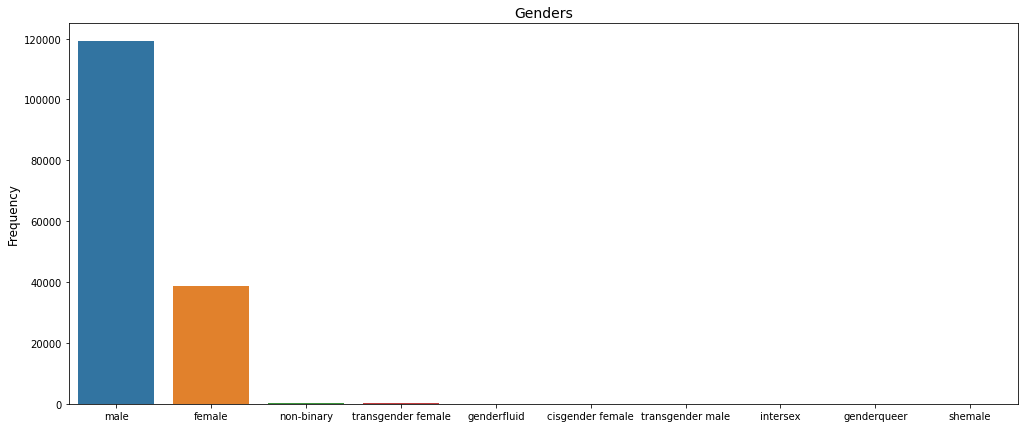

In [ ]:
# Visualisation of gender distribution
fig, ax = plt.subplots(figsize = (17,7))
sns.barplot(x=convert(df_2020["gender"]).value_counts().index,
        y=convert(df_2020["gender"]).value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Genders", size = 14)

A expected, the minorities are almost negligible in comparison to the two main genders. But it is still very intesting to notice their presence even in small numbers. We could make a further analysis on them but first we will concentrate on the repartition between male and female. Unsurprsingly, male speakers are quoted two times more than female ones. 

In [10]:
# Creation of DataFrame, male speakers
# The gender column contains lists. A mask is created to select values
# upon conditions in the list.
mask_males = df_2020.gender.apply(lambda x: 'male' in x)
males_df = df_2020[mask_males]
males_df.head(10)

NameError: ignored

In [ ]:
# Creation of DataFrame, female speakers
mask_females = df_2020.gender.apply(lambda x: 'female' in x)
females_df = df_2020[mask_females]
females_df.head()

,quoteID,quotation,speaker,date,numOccurrences,urls,newspapers,qid,gender,nationality,occupation
2,2020-01-11-002445,And help he always did. For someone who prefer...,Anna Wintour,2020-01-11 01:46:07,3,[https://www.irishmirror.ie/showbiz/celebrity-...,[Daily Mirror],Q230744,[female],[United Kingdom],"[journalist, fashion editor, writer, editor]"
3,2020-01-21-005435,And the symptoms of what a person goes through...,Taylor Swift,2020-01-21 15:58:39,8,[https://www.irishmirror.ie/showbiz/celebrity-...,[Daily Mirror],Q26876,[female],[United States of America],"[actor, pianist, banjoist, composer, guitarist..."
7,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times],Q242329,[female],[United States of America],"[film director, screenwriter, writer, film pro..."
8,2020-02-14-010581,Body confidence needs to be shouted about more...,Stacey Solomon,2020-02-14 15:20:22,1,[https://www.dailystar.co.uk/showbiz/loose-wom...,[Daily Star],Q439365,[female],[United Kingdom],"[singer, model, television presenter]"
11,2020-02-27-009528,But it really is that. The universe is a weird...,Melanie Johnston-Hollitt,2020-02-27 16:11:43,65,[http://andoveradvertiser.co.uk/news/national/...,"[The Daily Telegraph, Daily Express, Daily Mir...",Q50505758,[female],None,"[astrophysicist, researcher]"


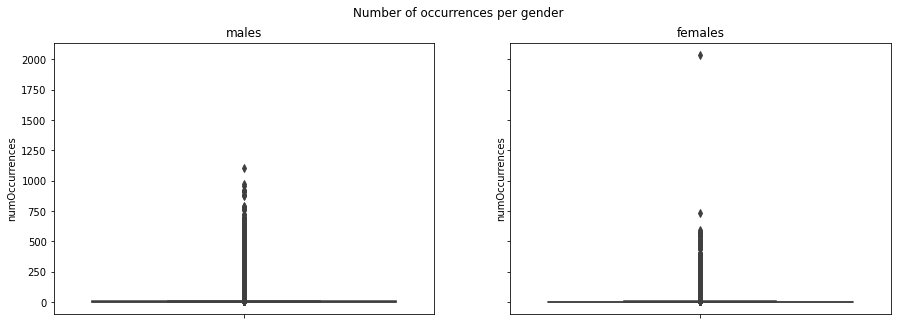

In [ ]:
# Distribution of male and female speakers regarding the number of occurrences of quotes
fig, axs = plt.subplots(1,2, sharey='row')
axs[0].set_title("males")
axs[1].set_title("females")
sns.boxplot(y='numOccurrences', data = males_df, ax = axs[0])
sns.boxplot(y='numOccurrences', data = females_df, ax = axs[1])
fig.suptitle('Number of occurrences per gender')
fig.set_size_inches(15,5)
plt.show()

There are seem to be some wide spread quotes. Let us have a look:

In [ ]:
females_df.loc[females_df.numOccurrences >= 300].shape

(69, 11)

In [ ]:
males_df.loc[males_df.numOccurrences >= 700].shape

(24, 11)

Seeing the distribution regarding the number of occurrences of quotes from male and female speakers, we can clearly see a stronger presence of male speakers in the newspapers. This supports the general hypothesis of a domination by men for quotes. This raises further questions for our analysis concerning: The evolution of this domination throughout the years and depending on different countries, the themes aborded by different genders or the representation of gender minorities.

We will look at one last thing. How many quotes are originated from men and female **depending on the newspaper** (for now just our three newspapers)? This will be important for our further analysis.

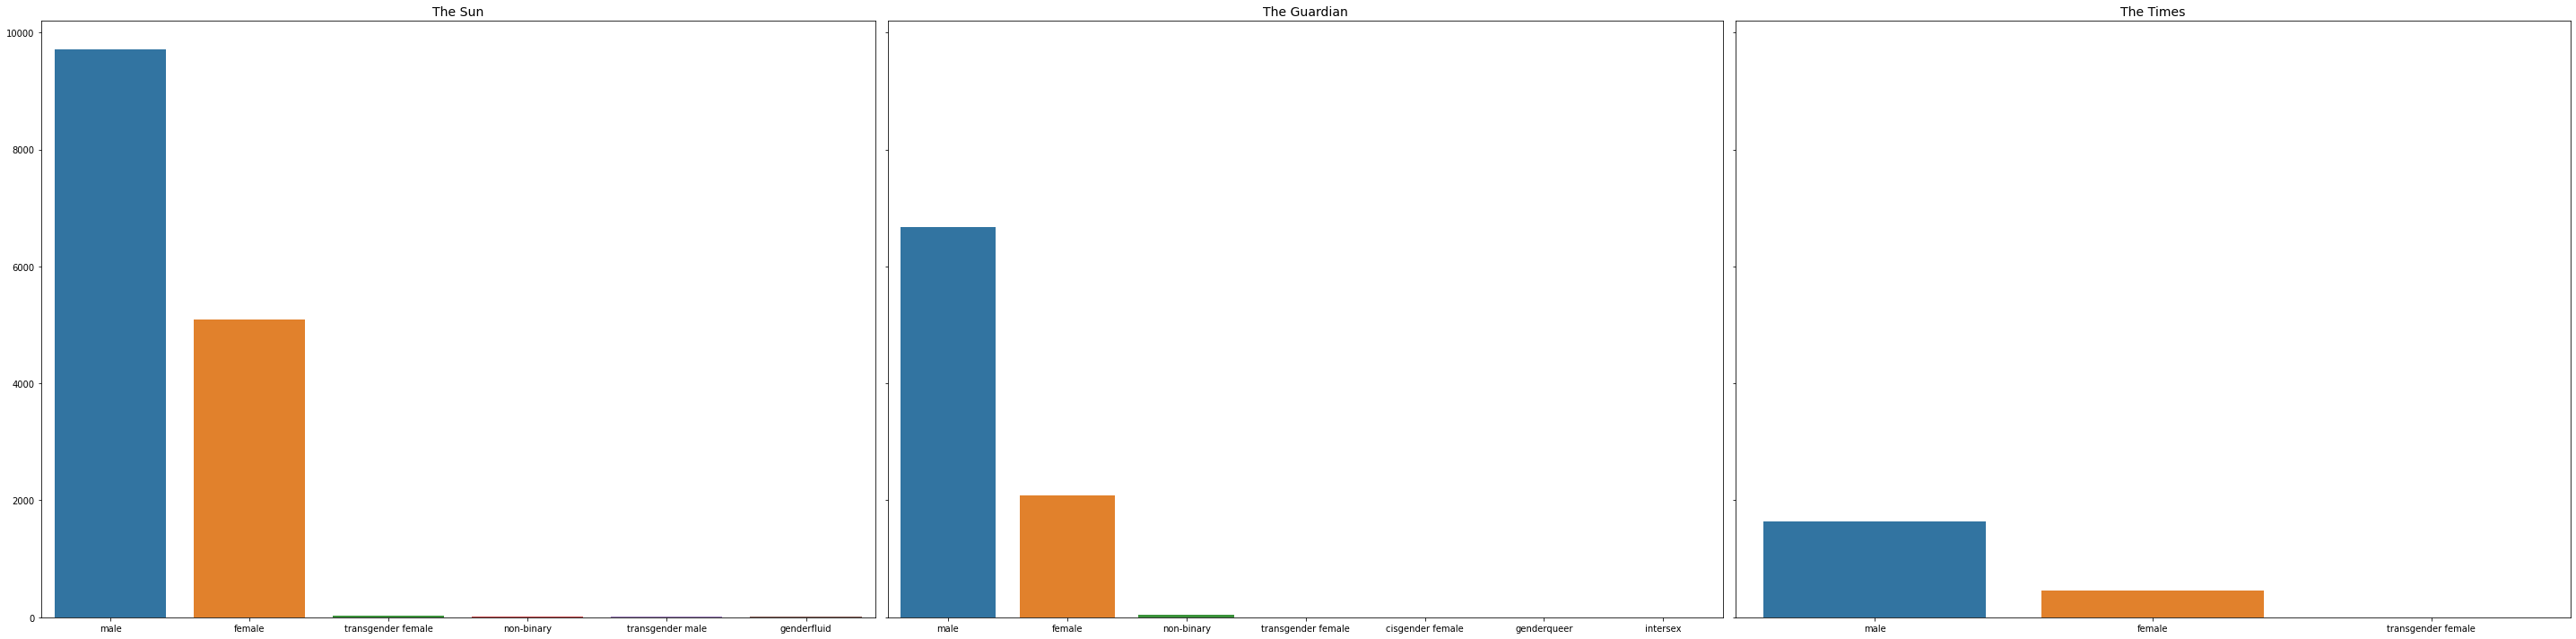

In [ ]:
#mask for each newspaper
mask_sun = df_2020.newspapers.apply(lambda x: 'The Sun' in x)
mask_guardian = df_2020.newspapers.apply(lambda x: 'The Guardian' in x)
mask_times = df_2020.newspapers.apply(lambda x: 'The Times' in x)

# we plot the distribution for each of them
fig, axs = plt.subplots(1,3, sharey='row', figsize = (40,10))

sns.barplot(x=convert(df_2020[mask_sun]['gender']).value_counts().index,
        y=convert(df_2020[mask_sun]['gender']).value_counts().values, ax = axs[0])
sns.barplot(x = convert(df_2020[mask_guardian]['gender']).value_counts().index,
        y=convert(df_2020[mask_guardian]['gender']).value_counts().values, ax = axs[1])
sns.barplot(x=convert(df_2020[mask_times]['gender']).value_counts().index,
        y=convert(df_2020[mask_times]['gender']).value_counts().values, ax = axs[2])

axs[0].set_title("The Sun", size = 14)
axs[1].set_title("The Guardian", size = 14)
axs[2].set_title("The Times", size = 14)
plt.tight_layout()

We can see that all three of newspapers have more quotes (twice as much) written by men than by women. We can also see that The Sun is the most cited newspaper, and The Times seems to include very few gender minorities.